In [12]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1
def add_metadata(fname, d):
    match = re.search('width_mult_\d+', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = int(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d
def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath)
            d = add_metadata(fp, d)
            d["name"] = fp
            final_d.append(d)
    return final_d
def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        try:
            if train:
                loss_d["train_loss"] =  d["metrics"]["train_loss"]
                loss_d["residual"] = d["metrics"]["residual"]
                loss_d["top_eig_ggn"] = d["metrics"]["top_eig_ggn"]
                if acc:
                    if "train_acc" in d["metrics"].keys():
                        loss_d["train_acc"] =  d["metrics"]["train_acc"]
                if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                    loss_d["trace"] = d["metrics"]["trace"]
                if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                    loss_d["top_eig"] = d["metrics"]["top_eig"]
            else:
                loss_d["test_loss"] =  d["metrics"]["test_loss"]
                loss_d["test_acc"] =  d["metrics"]["test_acc"]
            loss_d["lr"] = d["lr"]
            loss_d["width_mult"] = d["width_mult"]
            loss_d["depth_mult"] = d["depth_mult"]
            loss_d["step"] = loss_d.index
            loss_d["beta"] = d["beta"]
            loss_d["gamma_zero"] = d["gamma_zero"]
            loss_d["k_layers"] = d["k_layers"]
            loss_d["batch_size"] = d["batch_size"]
            ds.append(loss_d)
        except KeyError:
            continue
    return pd.concat(ds, axis=0)
def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [13]:
sns.set(style="whitegrid", font_scale=2.0, palette=sns.color_palette("rocket", n_colors=5))
plt.figure(figsize = (10,6))
folder_path = "/lustre/home/ameterez/work/icml2024/rebuttal/cifar10_ce/"
metric = "train_loss"
run_ds = get_data(folder_path, epoch=9)
df = loss_curves(run_ds, acc=False).reset_index()

<Figure size 1000x600 with 0 Axes>

In [26]:
lrs = sorted(df.lr.unique())
print(lrs)

[0.003162, 0.005275, 0.008799, 0.014678, 0.024484, 0.040842, 0.068129, 0.113646, 0.189574, 0.316228, 0.5275, 0.879923]


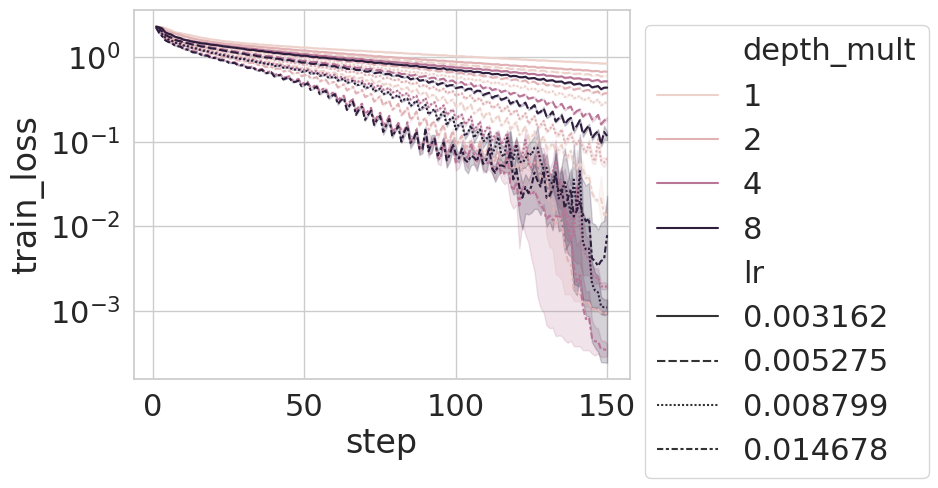

In [34]:
df2 = df[df['lr'].isin(lrs[0:4])]
df2 = df2[df2['width_mult'] == 4]
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='train_loss', hue='depth_mult', style='lr', ax=ax)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
fig.show()

In [33]:
df2

,index,train_loss,trace,top_eig,lr,width_mult,depth_mult,step,beta,gamma_zero,k_layers,batch_size
755,0,NaN,0.433901,0.064060,0.008799,1,4,0,3.0,1.0,1,64
756,1,2.312159,0.443456,0.052329,0.008799,1,4,1,3.0,1.0,1,64
757,2,2.222162,1.289728,0.209505,0.008799,1,4,2,3.0,1.0,1,64
758,3,2.095138,2.932100,0.725160,0.008799,1,4,3,3.0,1.0,1,64
759,4,1.909483,6.879039,1.962782,0.008799,1,4,4,3.0,1.0,1,64
...,...,...,...,...,...,...,...,...,...,...,...,...
110074,146,0.601617,24.246423,1.624802,0.005275,2,8,146,3.0,1.0,1,64
110075,147,0.595466,26.200147,1.621692,0.005275,2,8,147,3.0,1.0,1,64
110076,148,0.578871,26.216548,1.677576,0.005275,2,8,148,3.0,1.0,1,64
110077,149,0.591190,23.291639,1.559955,0.005275,2,8,149,3.0,1.0,1,64


In [23]:
width_mults = sorted(df['width_mult'].unique())
# depth_mults = sorted(df['depth_mult'].unique())
lrs = sorted(df['lr'].unique())

lr = lrs[0]


In [24]:
df

,index,train_loss,residual,top_eig_ggn,trace,top_eig,lr,width_mult,depth_mult,step,beta,gamma_zero,k_layers,batch_size
0,0,NaN,0.949257,3.085974,0.036933,0.004437,0.014678,4,1,0,3.0,1.0,1,256
1,1,2.325803,0.947386,3.413741,0.039353,0.004221,0.014678,4,1,1,3.0,1.0,1,256
2,2,2.208895,0.928314,44.550728,0.376476,0.044261,0.014678,4,1,2,3.0,1.0,1,256
3,3,1.980105,0.893815,238.982620,1.338405,0.233293,0.014678,4,1,3,3.0,1.0,1,256
4,4,1.872075,0.868522,379.657196,1.986659,0.369266,0.014678,4,1,4,3.0,1.0,1,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,6,1.867359,0.869564,395.855682,2.010552,0.386469,0.008799,4,1,6,3.0,1.0,1,256
414,7,1.799714,0.854295,552.197754,3.051916,0.537945,0.008799,4,1,7,3.0,1.0,1,256
415,8,1.733385,0.839095,681.343689,3.651216,0.663102,0.008799,4,1,8,3.0,1.0,1,256
416,9,1.680755,0.824449,835.202148,4.370481,0.814421,0.008799,4,1,9,3.0,1.0,1,256


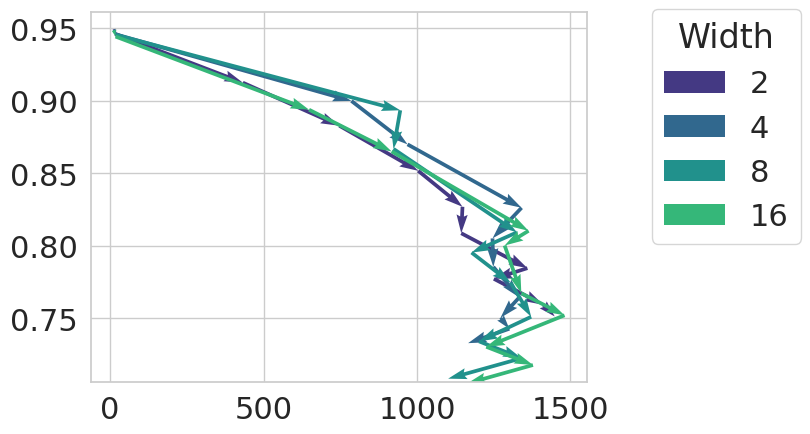

In [46]:
palette = sns.color_palette("viridis", n_colors=5)
sns.set(style="whitegrid", font_scale=2.0, palette=sns.color_palette("viridis", n_colors=5))

plt.figure()
lrs_plot = [lrs[-1], lrs[-2], lrs[-3], lrs[-4]]
width = 1000
a_min, a_max = None, None
b_min, b_max = None, None
for widthi, width in enumerate(width_mults):
    df2 = df[df['width_mult'] == width]
    df2 = df2[df2['lr'] == lrs[4]]
    a = df2.top_eig_ggn.values * (width)
    b = df2.residual.values 
    a_min = a.min()
    b_min = b.min()
    a_max = a.max()
    b_max = b.max()
    plt.quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, color=palette[widthi], label=f"{width}")
# plt.xlabel(r'$\lambda_{max}(\mathcal{G})$')
# plt.ylabel(r'$\lambda_{max}(B)$')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(a_min, a_max)
# plt.ylim(b_min-1, b_max+1)

plt.legend(bbox_to_anchor=(1.1, 1.05), title='Width')
# plt.title(r'$\mu$P')
plt.show()

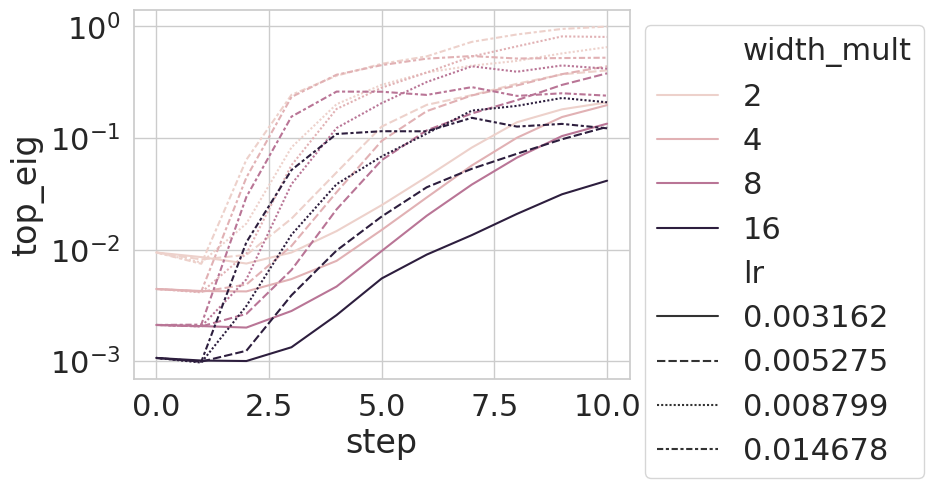

In [47]:
df2 = df[df['lr'].isin(lrs[0:4])]
df2['top_eig'] *= df2['width_mult']
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='top_eig', hue='width_mult', style='lr', ax=ax)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
fig.show()